In [1]:
import os
import glob
import copy
import random

from collections import defaultdict

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from torchvision.transforms.functional import rgb_to_grayscale

import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.losses import JaccardLoss, SoftCrossEntropyLoss, DiceLoss

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from tqdm import tqdm

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
params = {
    "data_dir": "/media/pipeh/Data/Datasets/vkitti/", #"D:/Datasets/vkitti/"
    "model_name": "vkitti_imgseg_v1.pt",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "lr": 0.0001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 50,
    "img_height": 256,
    "img_width": 256,
    "crop_size": 224
}

In [3]:
#                  Category      r g b
classes = { 0: ('Terrain', [210, 0, 200]),
            1 : ('Sky', [90, 200, 255]),
            2 : ('Tree', [0, 199, 0]),
            3 : ('Vegetation', [90, 240, 0]),
            4 : ('Building', [140, 140, 140]),
            5 : ('Road', [100, 60, 100]),
            6 : ('GuardRail', [250, 100, 255]),
            7 : ('TrafficSign', [255, 255, 0]),
            8 : ('TrafficLight', [200, 200, 0]),
            9 : ('Pole', [255, 130, 0]),
            10: ('Misc', [80, 80, 80]),
            11: ('Truck', [160, 60, 60]),
            12: ('Car', [255, 127, 80]),
            13: ('Van', [0, 139, 139]),
            #14: ('Undefined', [0, 0, 0])
          }

idx, b = list(zip(*list(classes.items())))
classes_names, color = zip(*b)

classes_idx = dict(zip(rgb_to_grayscale(torch.tensor([list(color)]).permute(2,0,1))[0][0].numpy(), list(idx)))
idx_to_rgb = dict(zip(list(idx),list(color)))

In [4]:
def get_files(params):
    #https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/
    img_files = glob.glob(params['data_dir']+'vkitti_2.0.3_rgb/*/*/frames/rgb/Camera_0/*.jpg')
    seg_files = glob.glob(params['data_dir']+'vkitti_2.0.3_classSegmentation/*/*/frames/classSegmentation/Camera_0/*.png')
    img_files.sort()
    seg_files.sort()

    data_files = list(zip(img_files, seg_files))
    random.Random(3141592).shuffle(data_files)

    img_files, seg_files = zip(*data_files)

    len_data = len(img_files)
    train_files = list(zip(img_files[:int(len_data*0.80)], seg_files[:int(len_data*0.80)]))
    test_files = list(zip(img_files[int(len_data*0.80):], seg_files[int(len_data*0.80):]))
    
    return train_files, test_files 

In [5]:
class VKITTIDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = read_image(self.files[idx][0])
        tar = read_image(self.files[idx][1])
        target_gray = rgb_to_grayscale(tar).squeeze(0)
        tar_gray = target_gray.detach().clone()
        for i in classes_idx.keys():
            tar_gray[target_gray==i] = classes_idx[i]
        target = tar_gray.unsqueeze(0)
        
        if self.transform:
            image = np.array(image.permute(1,2,0), dtype='float32')/255.
            target = np.array(target.permute(1,2,0), dtype='float32')
            transformed  = self.transform(image=image, mask=target)
            image = transformed["image"]
            target = transformed["mask"].permute(2,0,1)
            
        return image, target

In [6]:
data_transforms = {
    'train': A.Compose([
        A.RandomResizedCrop(height=params['img_height'], width=params['img_width'], scale=(0.8, 1.0)),
        A.CoarseDropout (max_holes=2, max_height=32, max_width=32, p=0.5),
        A.ShiftScaleRotate (shift_limit=0.00, scale_limit=0.00, rotate_limit=15, p=1.0),
        A.ColorJitter (p=1.0),
        A.HorizontalFlip (p=0.5),
        A.CenterCrop (height=params['crop_size'], width=params['crop_size'], p=1.0),
        A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2 (),
    ]),
    'test': A.Compose([
        A.Resize (height=params['img_height'], width=params['img_width']),
        A.CenterCrop (height=params['crop_size'], width=params['crop_size'], p=1.0),
        A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2 (),
    ]),
}

In [7]:
train_files, test_files = get_files(params)

In [8]:
dataset = dict()
dataloader = dict()

for x,y in zip(['train', 'test'],[train_files, test_files]):
    
    dataset[x] = VKITTIDataset(
        y, 
        transform=data_transforms[x])
    
    dataloader[x] = DataLoader(
        dataset[x],
        batch_size=params["batch_size"],
        shuffle=True,
    )
    
dataset_sizes = {x: len(dataset[x]) for x in ['train','test']}

print(f"dataset_sizes {dataset_sizes}")

dataset_sizes {'train': 17008, 'test': 4252}


In [9]:
def view_image(ds, samples=5):
    
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    
    image, target = next(iter(ds))
    image = image * std.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image + mean.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image.permute(0, 2, 3, 1).numpy()
    
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(5, 12))
    for i in range(samples):
        
        tar = target[i].repeat(3,1,1)
        for j in idx_to_rgb:
            tar[0][tar[0]==j] = idx_to_rgb[j][0]
            tar[1][tar[1]==j] = idx_to_rgb[j][1]
            tar[2][tar[2]==j] = idx_to_rgb[j][2]
        tar = tar.permute(1, 2, 0).numpy()/255.

        ax[i, 0].imshow(image[i])
        ax[i, 1].imshow(tar)
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

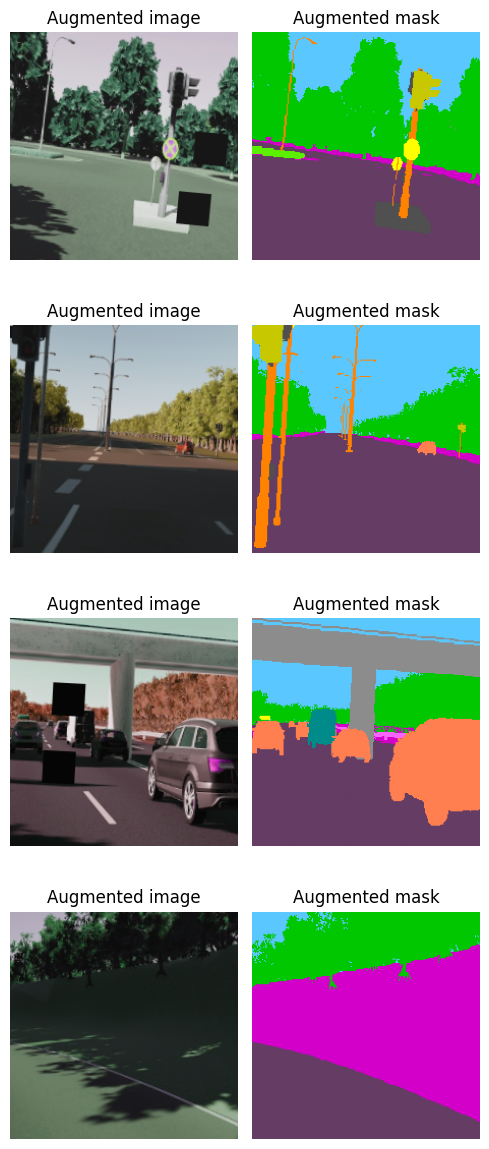

In [10]:
view_image(dataloader['train'], samples=4)

In [11]:
def count_class_imbalance(ds):
    class_count = dict(zip(list(idx), list(np.zeros(len(idx), dtype=np.int64))))
    
    for i, (_, target) in enumerate(ds):
        tar_count = target.unique(return_counts=True)
        for class_idx, count in zip(tar_count[0].numpy(), tar_count[1].numpy()):
            class_count[class_idx] = class_count[class_idx] + count
            
    return class_count

In [12]:
train_classes_count = count_class_imbalance(dataloader["train"])
print(train_classes_count)

{0: 98975729, 1: 166839921, 2: 202321668, 3: 10643506, 4: 26856354, 5: 256576484, 6: 6857267, 7: 5737316, 8: 2114642, 9: 7607007, 10: 6520741, 11: 7428855, 12: 49818145, 13: 5095773}


In [13]:
test_classes_count = count_class_imbalance(dataloader["test"])
print(test_classes_count)

{0: 33707909, 1: 31048061, 2: 59693643, 3: 4716052, 4: 8021671, 5: 50105607, 6: 2642142, 7: 1629430, 8: 580301, 9: 1748622, 10: 1737519, 11: 2165658, 12: 14059822, 13: 1491915}


In [43]:
classes_count = torch.tensor([ 99011568, 166783072, 202361450,  10651758,  26876521, 256553473,
          6882696,   5740306,   2108624,   7604264,   6513774,   7416042,
         49798741,   5091119])

In [14]:
classes_count = torch.tensor([train_classes_count[i] for i in train_classes_count])
total_pixels = torch.sum(classes_count)
classes_weights = classes_count / total_pixels

In [15]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [16]:
class GeneralizedDiceLoss(_Loss):
    def __init__(self, smooth=0.0, eps=1e-7):
        super(GeneralizedDiceLoss, self).__init__()
        self.eps = eps
        self.smooth = smooth
        
    def forward(self, y_pred, y_true):
        y_pred = y_pred.log_softmax(dim=1).exp()
        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)
        y_true = y_true.view(bs, -1)
        y_pred = y_pred.view(bs, num_classes, -1)
        y_true = F.one_hot(y_true, num_classes)
        y_true = y_true.permute(0, 2, 1)
        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)
        loss = 1.0 - scores
        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)
        return self.aggregate_loss(loss)
    
    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None):
        if dims is not None:
            intersection = torch.sum(output * target, dim=dims)
            cardinality = torch.sum(output + target, dim=dims)
        else:
            intersection = torch.sum(output * target)
            cardinality = torch.sum(output + target)
        dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
        return dice_score
        
    def aggregate_loss(self, loss):
        return loss.mean()

In [17]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.squeeze(1).to(torch.int64).to(params["device"], non_blocking=True)
        output = model(images)
        loss = 0.5*criterion[0](output, target) + 0.5*criterion[1](output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return model

In [18]:
def metrics(y_pred, y_true):
    bs = y_true.size(0)
    num_classes = y_pred.size(1)
    y_true = y_true.view(bs, -1)
    y_pred = y_pred.view(bs, num_classes, -1)
    y_pred = torch.argmax(y_pred, 1)         
    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multiclass', num_classes=num_classes)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
    return accuracy, recall, f1_score, iou_score

In [19]:
def validate(val_loader, model, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    f1_macro = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.squeeze(1).to(torch.int64).to(params["device"], non_blocking=True)
            output = model(images)
            accuracy, recall, f1_score, iou_score = metrics(output, target)
            metric_monitor.update("f1_macro", f1_score.item())
            metric_monitor.update("iou_score", iou_score.item())
            stream.set_description(
                "Epoch: {epoch}. Val. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            f1_macro += f1_score.item()
    return f1_score / i+1

In [20]:
def save_model(model, epoch, params):
    best_model_state = copy.deepcopy(model.state_dict())
    torch.save(best_model_state, params["model_name"])

In [21]:
def train_and_validate(model, train_loader, val_loader, params):    
    loss_1 = nn.CrossEntropyLoss(weight=classes_weights, label_smoothing=0.1).to(params["device"])
    loss_2 = GeneralizedDiceLoss(smooth=0.1).to(params["device"])
    criterion = [loss_1, loss_2]
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    max_score = 0
    for epoch in range(1, params["epochs"] + 1):
        model = train(train_loader, model, criterion, optimizer, epoch, params)
        f1_score = validate(val_loader, model, epoch, params)
        if f1_score >= max_score:
            save_model(model, epoch, params)
            max_score = f1_score
    return model

In [22]:
def create_model(params):
    model = smp.MAnet(
        encoder_name="mit_b0",
        encoder_weights="imagenet",
        in_channels=3,
        classes=len(classes_names),
    )
    total_params = sum(p.numel() for p in model.parameters())
    print(f"numero de parametros: {total_params}")
    for name, param in model.named_parameters():
        if name.startswith("encoder"):
            param.requires_grad = False
    model = model.to(params["device"])
    return model

In [23]:
model = create_model(params)

numero de parametros: 7665326


In [24]:
model = train_and_validate(model, dataloader['train'], dataloader['test'], params)

Epoch: 1. Train.      Loss: 0.913: 100%|██████| 266/266 [05:02<00:00,  1.14s/it]
Epoch: 1. Val. f1_macro: 0.238 | iou_score: 0.205: 100%|█| 67/67 [00:58<00:00,  
Epoch: 2. Train.      Loss: 0.524: 100%|██████| 266/266 [04:49<00:00,  1.09s/it]
Epoch: 2. Val. f1_macro: 0.315 | iou_score: 0.281: 100%|█| 67/67 [00:55<00:00,  
Epoch: 3. Train.      Loss: 0.460: 100%|██████| 266/266 [04:40<00:00,  1.05s/it]
Epoch: 3. Val. f1_macro: 0.369 | iou_score: 0.328: 100%|█| 67/67 [00:54<00:00,  
Epoch: 4. Train.      Loss: 0.427: 100%|██████| 266/266 [04:45<00:00,  1.07s/it]
Epoch: 4. Val. f1_macro: 0.430 | iou_score: 0.382: 100%|█| 67/67 [00:59<00:00,  
Epoch: 5. Train.      Loss: 0.398: 100%|██████| 266/266 [04:37<00:00,  1.04s/it]
Epoch: 5. Val. f1_macro: 0.460 | iou_score: 0.405: 100%|█| 67/67 [00:56<00:00,  
Epoch: 6. Train.      Loss: 0.363: 100%|██████| 266/266 [04:32<00:00,  1.02s/it]
Epoch: 6. Val. f1_macro: 0.577 | iou_score: 0.490: 100%|█| 67/67 [00:55<00:00,  
Epoch: 7. Train.      Loss: 

In [25]:
model.load_state_dict(torch.load(params["model_name"], map_location=torch.device('cpu')))
model = model.to(params["device"])
model.eval()

MAnet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, 

In [26]:
def metrics_test(y_pred, y_true):
    bs = y_true.size(0)
    num_classes = y_pred.size(1)
    y_true = y_true.view(bs, -1)
    y_pred = y_pred.view(bs, num_classes, -1)
    y_pred = torch.argmax(y_pred, 1)         
    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multiclass', num_classes=num_classes)
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction=None)
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction=None)
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction=None)
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction=None)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None)
    return accuracy, precision, recall, f1_score, iou_score

In [27]:
def test(val_loader, model, params):
    metric_monitor = MetricMonitor()
    stream = tqdm(val_loader)
    accuracy = torch.tensor([])
    precision = torch.tensor([])
    recall = torch.tensor([])
    f1_score = torch.tensor([])
    iou_score = torch.tensor([])
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.squeeze(1).to(torch.int64).to(params["device"], non_blocking=True)
            output = model(images)
            acc, prc, rcl, f1, iou = metrics_test(output, target)
            stream.set_description(
                "Test. {metric_monitor}".format(metric_monitor=metric_monitor)
            )
            accuracy = torch.cat((accuracy, acc),0)
            precision = torch.cat((precision, prc),0)
            recall = torch.cat((recall, rcl),0)
            f1_score = torch.cat((f1_score, f1),0)
            iou_score = torch.cat((iou_score, iou),0)
    f1_score = torch.mean(f1_score, 0)
    accuracy = torch.mean(accuracy, 0)
    precision = torch.mean(precision, 0)
    recall = torch.mean(recall, 0)
    iou_score = torch.mean(iou_score, 0)
    return f1_score, accuracy, precision, recall, iou_score

In [28]:
f1_score, accuracy, precision, recall, iou_score = test(dataloader["test"], model, params)

Test. : 100%|███████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


In [29]:
maxlen = len(max(classes_names, key=len))
format_names = [(' ' * (maxlen - len(x))) + x for x in classes_names]

print("              Precision    Recall    F1-Score    IoU-Score")
print(" ")
for i in range(len(format_names)):
    print(f"{format_names[i]}:   {precision[i]:.3f}       {recall[i]:.3f}       {f1_score[i]:.3f}        {iou_score[i]:.3f}")
print(" ")
print(f"    accuracy:                           {torch.mean(accuracy, 0):.3f}")
print(f"   macro avg:   {torch.mean(precision, 0):.3f}       {torch.mean(recall, 0):.3f}       {torch.mean(f1_score, 0):.3f}        {torch.mean(iou_score, 0):.3f}")

              Precision    Recall    F1-Score    IoU-Score
 
     Terrain:   0.922       0.835       0.871        0.791
         Sky:   0.935       0.947       0.940        0.890
        Tree:   0.901       0.958       0.927        0.869
  Vegetation:   0.916       0.921       0.885        0.853
    Building:   0.867       0.656       0.622        0.581
        Road:   0.962       0.976       0.969        0.940
   GuardRail:   0.964       0.865       0.869        0.841
 TrafficSign:   0.858       0.453       0.478        0.407
TrafficLight:   0.934       0.751       0.757        0.732
        Pole:   0.569       0.213       0.210        0.154
        Misc:   0.815       0.601       0.574        0.548
       Truck:   0.919       0.879       0.833        0.816
         Car:   0.839       0.866       0.827        0.746
         Van:   0.863       0.727       0.683        0.649
 
    accuracy:                           0.991
   macro avg:   0.876       0.761       0.746        0.701


In [30]:
def view_predictions(model, ds, samples=5):
    
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    
    image, target = next(iter(ds))
    with torch.no_grad():
        image = image.to(params["device"])
        output = model(image)
        output = torch.argmax(output, 1)
    output = output.to("cpu")
    image = image.to("cpu")
    image = image * std.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image + mean.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image.permute(0, 2, 3, 1).numpy()
    
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        
        tar = output[i].repeat(3,1,1)
        for j in idx_to_rgb:
            tar[0][tar[0]==j] = idx_to_rgb[j][0]
            tar[1][tar[1]==j] = idx_to_rgb[j][1]
            tar[2][tar[2]==j] = idx_to_rgb[j][2]
        tar = tar.permute(1, 2, 0).numpy()/255.

        ax[i, 0].imshow(image[i])
        ax[i, 1].imshow(tar)
        ax[i, 0].set_title("image")
        ax[i, 1].set_title("predicted mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

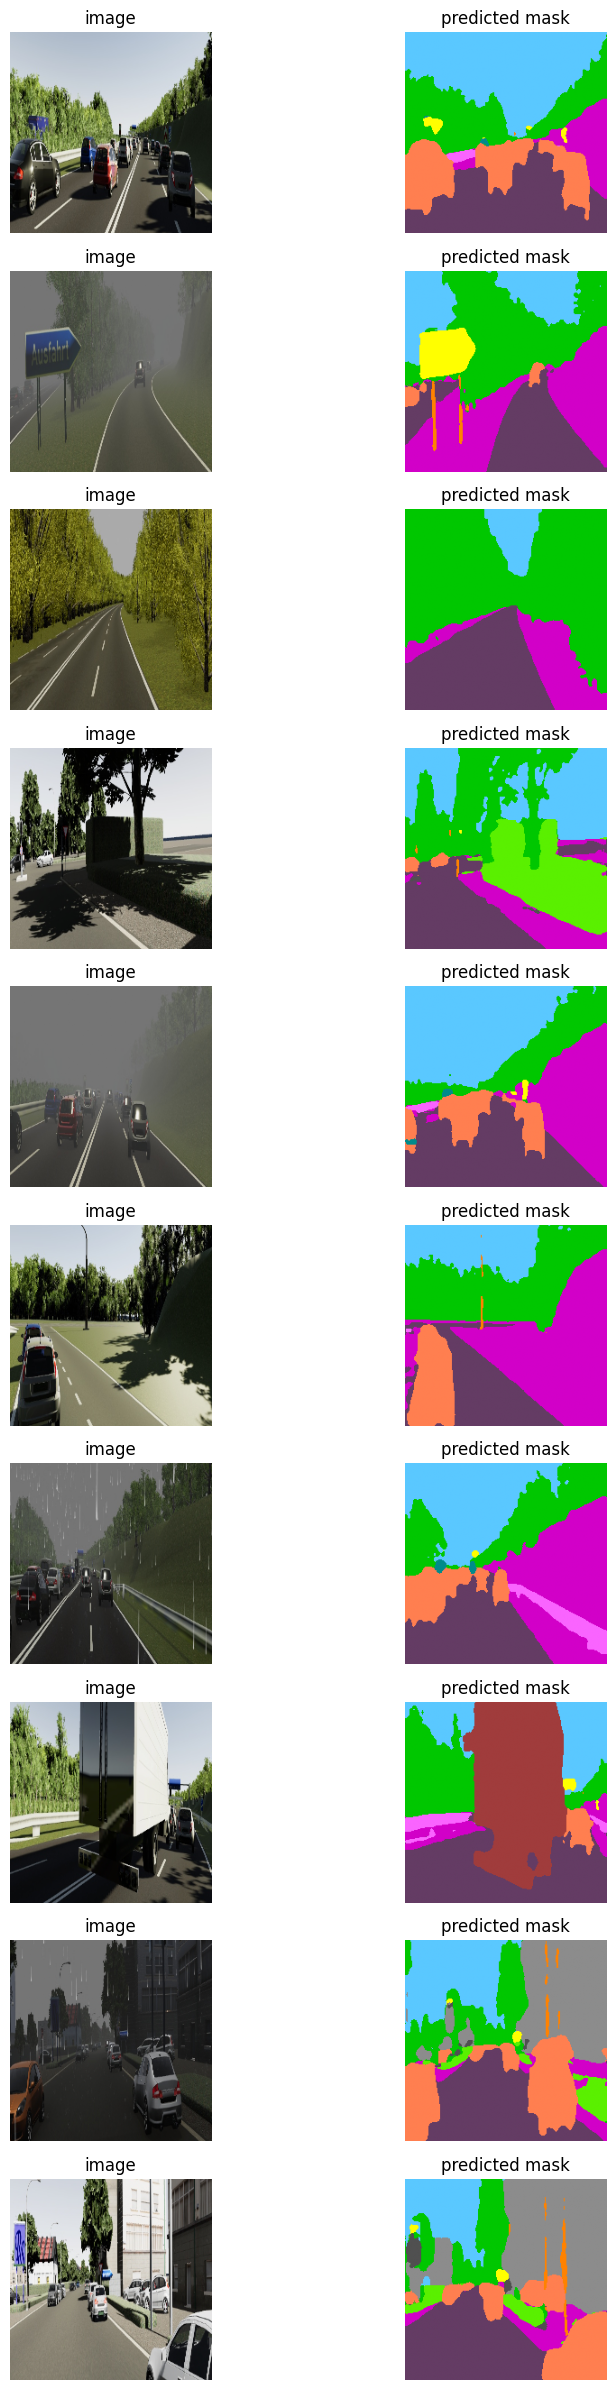

In [31]:
view_predictions(model, dataloader['test'], samples=10)